In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


In [2]:
folder_name = input("Please enter the subject name: ")

Define the dataset

In [3]:
# Define the column names
column_names = ['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']
df = []
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            df_temp = pd.read_csv(file_path, header=None)
            df.append(df_temp)     
    combined_data_array_3d = np.array(df)
    combined_data_array_2d= combined_data_array_3d.reshape(40 * 10000, 21)
    
Combined_raw_eeg = pd.DataFrame(combined_data_array_2d) 
Combined_raw_eeg.columns = column_names

#Excluding the useless columns
columns_to_remove = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Battery', 'Sample', 'Unknown','Instruction','Female/Male', 'Outdoor/Indoor', 'Human Behavior']
Combined_raw_eeg = Combined_raw_eeg.drop(columns=columns_to_remove, axis=1)

# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

Combined_raw_eeg_bp = np.copy(Combined_raw_eeg)
num_columns = Combined_raw_eeg_bp.shape[1]

for column in range(num_columns):
    Combined_raw_eeg_bp[:, column] = butter_bandpass_filter(Combined_raw_eeg_bp[:, column], lowcut=.1, highcut=30, fs=250)

# Pre-proccessing
# Denoising 
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

Combined_raw_eeg_bp=pd.DataFrame(Combined_raw_eeg_bp)
eeg_df_denoised = preprocess(Combined_raw_eeg_bp, col_names=list(Combined_raw_eeg_bp.columns), n_clusters=[50]*len(Combined_raw_eeg_bp.columns))

# Lableing
column_indices = {'Instruction': 17, 'Female/Male': 18, 'Outdoor/Indoor': 19}
selected_columns = [column_indices['Instruction'], column_indices['Female/Male'], column_indices['Outdoor/Indoor']]
data_im_ins = combined_data_array_2d[:, selected_columns]
denoised_im_ins = np.concatenate((eeg_df_denoised, data_im_ins), axis=1)

# Check the third last column (column 9) and keep rows if column 9 is equal to 1
filtered_denoised_im_ins = denoised_im_ins[(denoised_im_ins[:, -3] == denoised_im_ins[:, -2]) | (denoised_im_ins[:, -3] == denoised_im_ins[:, -1])]
filtered_denoised_im_ins_df = pd.DataFrame(filtered_denoised_im_ins)

# Create a new column 'event'
filtered_denoised_im_ins_df['event'] = ''
for index, row in filtered_denoised_im_ins_df.iterrows():
    if row.iloc[-4] == 'F' or row.iloc[-4] == 'M':
        filtered_denoised_im_ins_df.at[index, 'event'] = '0'
    elif row.iloc[-4] == 'I' or row.iloc[-4] == 'O':
        filtered_denoised_im_ins_df.at[index, 'event'] = '1'
        
selected_data = filtered_denoised_im_ins_df.iloc[:, :8]  
lable=filtered_denoised_im_ins_df.iloc[:, -1:]


Windowing

In [4]:
win_size = 250
X = []
y = []

for i in range(0, len(selected_data), win_size):
    window_data = selected_data.iloc[i:i+win_size]
    window_label = lable.iloc[i:i+win_size]
    X.append(window_data)
    y.append(window_label)

X = np.array(X)
y = np.array(y)
X, y = shuffle(X, y)

In [5]:
print(X.shape, y.shape)

(1440, 250, 8) (1440, 250, 1)


In [6]:
array_3d = X.reshape(1440, 5, 50, 8)
array_3d_mean = array_3d.mean(axis=1)
print(array_3d_mean.shape) # Output: (1440, 24, 8)


(1440, 50, 8)


In [105]:
print(X.shape, y.shape)

(1440, 250, 8) (1440, 250, 1)


In [7]:
print(y)

[[['1']
  ['1']
  ['1']
  ...
  ['1']
  ['1']
  ['1']]

 [['0']
  ['0']
  ['0']
  ...
  ['0']
  ['0']
  ['0']]

 [['0']
  ['0']
  ['0']
  ...
  ['0']
  ['0']
  ['0']]

 ...

 [['0']
  ['0']
  ['0']
  ...
  ['0']
  ['0']
  ['0']]

 [['0']
  ['0']
  ['0']
  ...
  ['0']
  ['0']
  ['0']]

 [['0']
  ['0']
  ['0']
  ...
  ['0']
  ['0']
  ['0']]]


In [11]:
y_n=np.squeeze(y[:,0])
print(y_n)
print(y_n[20], y[20])

['1' '0' '0' ... '0' '0' '0']
0 [['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 [

Considering each 40 milliseconds as one sample

In [12]:
reshaped_X = array_3d_mean
reshaped_y = y
# y_temp=reshaped_y.reshape(288,1)

X_n = reshaped_X.reshape(reshaped_X.shape[0], reshaped_X.shape[1]*reshaped_X.shape[2])
y_n=np.squeeze(y[:,0])
print(X_n.shape, y_n.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_n, y_n)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)

(1440, 400) (1440,)


In [13]:
print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

X_train: (1166, 400) y_train: (1166, 2) X_test: (130, 400) y_test: (130, 2) X_untouch: (144, 400) y_untouch: (144, 2)


Data visualization

In [ ]:
#Raw data
eeg_df_raw_samples = Combined_raw_eeg.iloc[11000:50000]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 4))  
axes = axes.flatten()  
for i, column in enumerate(eeg_df_raw_samples.columns):
    ax = axes[i] 
    ax.plot(eeg_df_raw_samples.index, eeg_df_raw_samples[column])
    ax.set_xlabel('Sample Number (Row Number)')
    ax.set_ylabel('Data')
    ax.set_title(f'Raw EEG Data for Column: {column}_{folder_name}')
plt.tight_layout() 
plt.savefig(f'Raw_eeg_data_{folder_name}.jpg', dpi=300)
plt.show()

#Bandpassed data
eg_df_bandpass_samples = Combined_raw_eeg_bp.iloc[11000:50000]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 4))  
axes = axes.flatten()  
for i, column in enumerate(eg_df_bandpass_samples.columns):
    ax = axes[i]  
    ax.plot(eg_df_bandpass_samples.index, eg_df_bandpass_samples[column])
    ax.set_xlabel('Sample Number (Row Number)')
    ax.set_ylabel('Data')
    ax.set_title(f'Bandpass EEG Data for Column: {column}_{folder_name}')
plt.tight_layout()  
plt.savefig(f'Band_pass_eeg_data_{folder_name}.jpg', dpi=300)  
plt.show()

#Denoised data
eeg_df_denoised_samples = eeg_df_denoised.iloc[11000:50000]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 4))  
axes = axes.flatten()  
for i, column in enumerate(eeg_df_denoised_samples.columns):
    ax = axes[i]  
    ax.plot(eeg_df_denoised_samples.index, eeg_df_denoised_samples[column])
    ax.set_xlabel('Sample Number (Row Number)')
    ax.set_ylabel('Data')
    ax.set_title(f'Denoised EEG Data for Column: {column}_{folder_name}')
plt.tight_layout() 
plt.savefig(f'Denoised_eeg_data_{folder_name}.jpg.jpg', dpi=300)  
plt.show()

MLP

In [109]:
def create_model(num_layers=1, layer_width=64, activation='relu',
                 batch_norm=False, dropout_rate=0.0, 
                 learning_rate=0.05, optimizer='rmsprop'):

    model = Sequential()
    
    # Add the input layer
    model.add(Dense(200, input_shape=(400,)))
    
    # Add the hidden layers
    for i in range(num_layers):
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dense(layer_width, activation=activation))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    # Add the output layer
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Define the parameters and employ the grid research

In [110]:
model_MLP = KerasClassifier(build_fn=create_model)
params = dict(optimizer=['adam', 'rmsprop'], nb_epoch=[200], batch_size=[4], activation=['relu'],num_layers=[1,2], layer_width=[100,50],
              batch_norm=[False, True], dropout_rate=[0], learning_rate=[0.0001])
grid = GridSearchCV(estimator=model_MLP, param_grid=params)
grid_result = grid.fit(X_train, y_train)

C:\Users\tnlab\AppData\Local\Temp\ipykernel_19084\4159462427.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_MLP = KerasClassifier(build_fn=create_model)


292/292 [==============================] - 1s 1ms/step - loss: 0.7486 - accuracy: 0.5223


Plot the grid research results

In [23]:
# Get the mean validation score for each set of hyperparameters
mean_val_scores = grid_result.cv_results_['mean_test_score']
# fig = plt.figure(figsize=(30,10))
# plt.plot(mean_val_scores)
# plt.title('Grid Search Results',fontsize=22 )
# plt.xlabel('Hyperparameter Set', fontsize=20)
# plt.ylabel('Mean Validation Score', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# fig.savefig(f'grid_search_results{folder_name}.png', dpi=300)
# Print the best hyperparameters and their corresponding accuracy score
print(f"Best hyperparameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Best hyperparameters: {'activation': 'relu', 'batch_norm': False, 'batch_size': 32, 'dropout_rate': 0.01, 'layer_width': 1000, 'learning_rate': 0.001, 'nb_epoch': 20, 'num_layers': 2, 'optimizer': 'adam'}
Best accuracy: 0.5162723243236542


Fit the final MLP model

In [24]:
best_params = grid_result.best_params_
best_model_MLP = create_model(num_layers=best_params['num_layers'], layer_width=best_params['layer_width'],
                     activation=best_params['activation'], batch_norm=best_params['batch_norm'],
                     dropout_rate=best_params['dropout_rate'], learning_rate=best_params['learning_rate'],
                     optimizer=best_params['optimizer'])
history = best_model_MLP.fit(X_train, y_train, epochs=best_params['nb_epoch'], validation_data=(X_test, y_test)) 

Epoch 1/20
37/37 [==============================] - 2s 39ms/step - loss: 4.0512 - accuracy: 0.4914 - val_loss: 1.6503 - val_accuracy: 0.5846
Epoch 2/20
37/37 [==============================] - 1s 35ms/step - loss: 1.6379 - accuracy: 0.5009 - val_loss: 1.2495 - val_accuracy: 0.5077
Epoch 3/20
37/37 [==============================] - 1s 35ms/step - loss: 1.4831 - accuracy: 0.5009 - val_loss: 0.8949 - val_accuracy: 0.5923
Epoch 4/20
37/37 [==============================] - 1s 35ms/step - loss: 1.7160 - accuracy: 0.5077 - val_loss: 1.4209 - val_accuracy: 0.4308
Epoch 5/20
37/37 [==============================] - 1s 35ms/step - loss: 0.9851 - accuracy: 0.5317 - val_loss: 0.7133 - val_accuracy: 0.5154
Epoch 6/20
37/37 [==============================] - 1s 35ms/step - loss: 0.8357 - accuracy: 0.5146 - val_loss: 0.6909 - val_accuracy: 0.5231
Epoch 7/20
37/37 [==============================] - 1s 35ms/step - loss: 0.7994 - accuracy: 0.4983 - val_loss: 0.7574 - val_accuracy: 0.5231
Epoch 8/20
37

Evaluate the MLP model on untouched data

In [116]:
evaluation_MLP = best_model_MLP.evaluate(X_untouch, y_untouch)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_92/dense_323/BiasAdd' defined at (most recent call last):
    File "c:\Users\tnlab\miniconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\tnlab\miniconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\tnlab\miniconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\tnlab\miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\tnlab\miniconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\tnlab\miniconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\tnlab\miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\tnlab\miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\tnlab\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tnlab\AppData\Local\Temp\ipykernel_19084\1566556756.py", line 1, in <module>
      evaluation_MLP = best_model_MLP.evaluate(X_untouch, y_untouch)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 2072, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 1852, in test_function
      return step_function(self, iterator)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 1836, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 1824, in run_step
      outputs = model.test_step(data)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 1788, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tnlab\miniconda3\lib\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'sequential_92/dense_323/BiasAdd'
Matrix size-incompatible: In[0]: [32,400], In[1]: [2000,1000]
	 [[{{node sequential_92/dense_323/BiasAdd}}]] [Op:__inference_test_function_755107]

MLP Model Accuracy Plot

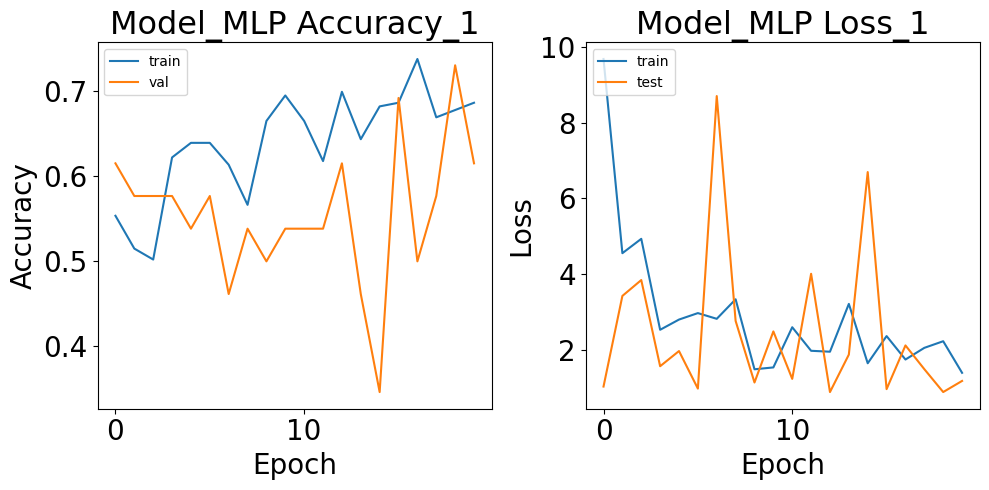

In [38]:
# Model Accuracy Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title(f'Model_MLP Accuracy_{folder_name}', fontsize=23)
ax1.set_xlabel('Epoch', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.legend(['train', 'val'], loc='upper left')
ax1.tick_params(axis='both', labelsize=20)

# Model Loss Plot
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title(f'Model_MLP Loss_{folder_name}', fontsize=23)
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_ylabel('Loss', fontsize=20)
ax2.legend(['train', 'test'], loc='upper left')
ax2.tick_params(axis='both', labelsize=20)

plt.tight_layout()  
plt.show()
fig.savefig(f'Model_MLP_Accuracy_and_Loss_{folder_name}.png', dpi=300)

MLP prediction/evaluation results

1/1 [==============================] - 0s 16ms/step
Precision for each class:
Class 0: 0.7500
Class 1: 0.5294


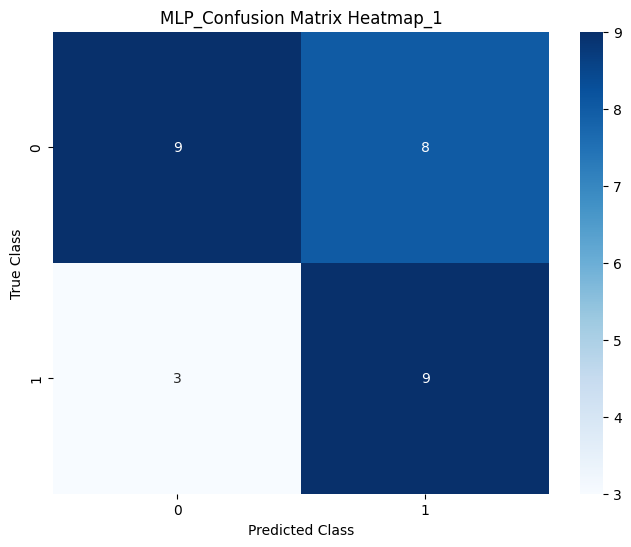

In [29]:
y_pred_MLP = best_model_MLP.predict(X_untouch)
y_pred_MLP_classes = np.argmax(y_pred_MLP, axis=-1)
np.save(f'MLP_preds(Matrix)_{folder_name}.npy', y_pred_MLP)
np.save(f'MLP_preds(labes)_{folder_name}.npy', y_pred_MLP_classes)

y_true_MLP_classes = np.argmax(y_untouch, axis=-1) # Convert one-hot-encoded true labels to integer-encoded labels

# Compute the confusion matrix
cm = confusion_matrix(y_true_MLP_classes, y_pred_MLP_classes)
# Calculate the precision for each class
n_classes = cm.shape[0]
class_MLP_precisions = []
for i in range(n_classes):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    
    precision = tp / (tp + fp)
    class_MLP_precisions.append(precision)

print("Precision for each class:")
for i, precision in enumerate(class_MLP_precisions):
    print(f"Class {i}: {precision:.4f}")
    
    
column_names = ['Subject ID','Loss', 'Accuracy' ] + [f'Precision_Class_{i}' for i in range(len(class_MLP_precisions))]
dataset_name = folder_name  
new_data = [dataset_name, evaluation_MLP[0], evaluation_MLP[1]] + class_MLP_precisions
new_results_df = pd.DataFrame(data=[new_data], columns=column_names)

# Check if the Excel file exists
filename = 'evaluation_results_MLP.xlsx'
if os.path.isfile(filename):
    existing_results_df = pd.read_excel(filename) # Read the existing Excel file
    results_df = pd.concat([existing_results_df, new_results_df], ignore_index=True) # Append the new row to the existing DataFrame
else:
    results_df = new_results_df # If the file does not exist, use the new DataFrame as the results DataFrame

results_df.to_excel(filename, index=False)

# Compute the confusion matrix
cm = confusion_matrix(y_true_MLP_classes, y_pred_MLP_classes)

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax)
ax.set_title(f'MLP_Confusion Matrix Heatmap_{folder_name}')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
fig.savefig(f'MLP_Heatmap_{folder_name}.jpg', dpi=300)
plt.show()

Define the input for CNN

In [14]:
X_train_reshaped_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], 1,1)
X_test_reshaped_CNN= X_test.reshape(X_test.shape[0], X_test.shape[1], 1,1)
print(X_train_reshaped_CNN.shape, X_test_reshaped_CNN.shape)

(1166, 400, 1, 1) (130, 400, 1, 1)


CNN

In [26]:
model_CNN = Sequential([
    # First Convolutional Layer
    Conv2D(50, kernel_size=(1, 1), input_shape=(400, 1, 1)),
    # MaxPooling2D(pool_size=(2, 1)),
    # Conv2D(64, kernel_size=(1, 1), activation='relu'),
    
    # Conv2D(128, kernel_size=(1, 1), activation='relu'),
    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    Dense(2, activation='softmax')
])
custom_lr = 0.00001
optimizer = Adam(learning_rate=custom_lr)
model_CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model_CNN.fit(X_train_reshaped_CNN, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped_CNN, y_test))

Epoch 1/20
37/37 [==============================] - 1s 14ms/step - loss: 0.6949 - accuracy: 0.4923 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6948 - val_accuracy: 0.4462
Epoch 3/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6944 - accuracy: 0.5163 - val_loss: 0.6957 - val_accuracy: 0.5231
Epoch 4/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6969 - val_accuracy: 0.4923
Epoch 5/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6927 - accuracy: 0.5403 - val_loss: 0.6965 - val_accuracy: 0.4769
Epoch 6/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6935 - accuracy: 0.5274 - val_loss: 0.7013 - val_accuracy: 0.5077
Epoch 7/20
37/37 [==============================] - 0s 11ms/step - loss: 0.6925 - accuracy: 0.5497 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 8/20
37

Evaluate the CNN model

In [127]:
X_untouch_reshaped_CNN = X_untouch.reshape(X_untouch.shape[0], X_untouch.shape[1], 1,1)
evaluation_CNN=model_CNN.evaluate(X_untouch_reshaped_CNN , y_untouch)

5/5 [==============================] - 0s 49ms/step - loss: 0.6931 - accuracy: 0.5139


CNN Model Accuracy Plot

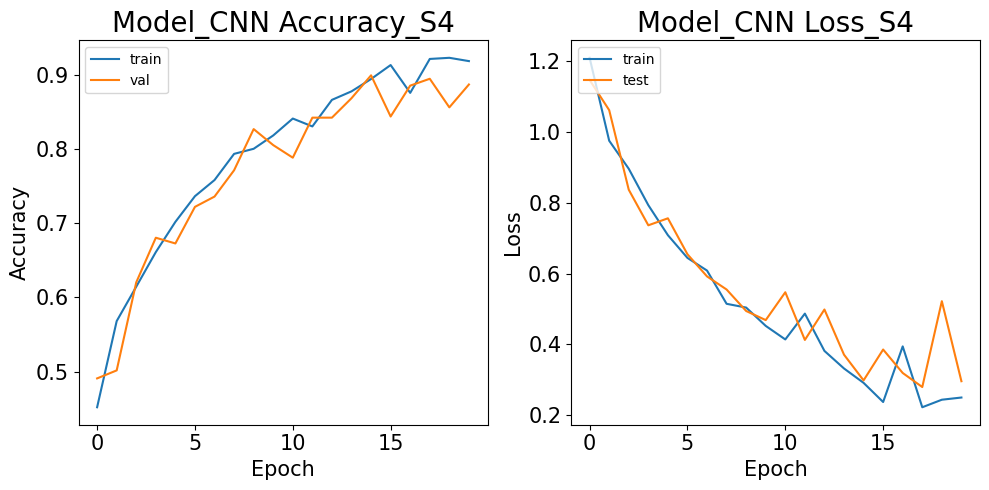

In [322]:
# Model Accuracy Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title(f'Model_CNN Accuracy_{folder_name}', fontsize=20)
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_ylabel('Accuracy', fontsize=15)
ax1.legend(['train', 'val'], loc='upper left')
ax1.tick_params(axis='both', labelsize=15)

# Model Loss Plot
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title(f'Model_CNN Loss_{folder_name}', fontsize=20)
ax2.set_xlabel('Epoch', fontsize=15)
ax2.set_ylabel('Loss', fontsize=15)
ax2.legend(['train', 'test'], loc='upper left')
ax2.tick_params(axis='both', labelsize=15)

plt.tight_layout()  
plt.show()
fig.savefig(f'Model_CNN_Accuracy_and_Loss_{folder_name}.png', dpi=300)

CNN prediction/evaluation results

23/23 [==============================] - 0s 5ms/step
Precision for each class:
Class 0: 0.8633
Class 1: 0.8704
Class 2: 0.8769
Class 3: 0.9059


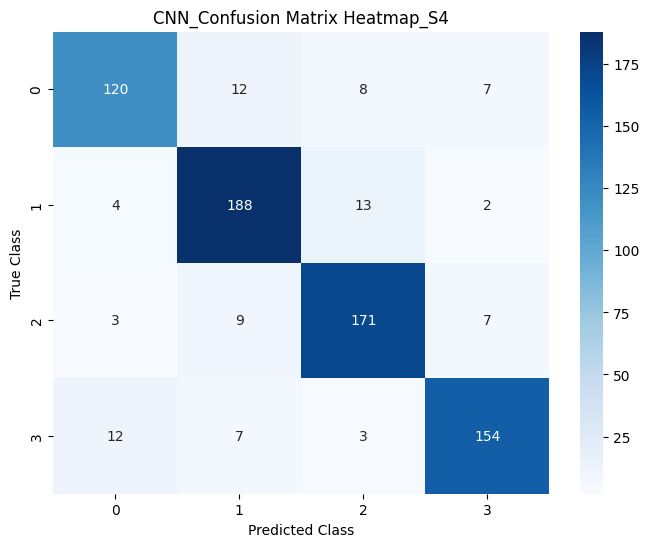

In [323]:
y_pred_CNN =model_CNN.predict(X_untouch_reshaped_CNN)
y_pred_classes_CNN = np.argmax(y_pred_CNN, axis=-1)
y_true_classes_CNN = np.argmax(y_untouch, axis=-1) # Convert one-hot-encoded true labels to integer-encoded labels

np.save(f'CNN_preds(Matrix)_{folder_name}.npy', y_pred_CNN)
np.save(f'CNN_preds(labes)_{folder_name}.npy', y_pred_classes_CNN)

# Compute the confusion matrix
cm_cnn = confusion_matrix(y_true_classes_CNN, y_pred_classes_CNN)

# Calculate the precision for each class
n_classes = cm_cnn.shape[0]
class_precisions_cnn = []
for i in range(n_classes):
    tp = cm_cnn[i, i]
    fp = np.sum(cm_cnn[:, i]) - tp
    precision = tp / (tp + fp)
    class_precisions_cnn.append(precision)

# Print the precision for each class
print("Precision for each class:")
for i, precision in enumerate(class_precisions_cnn):
    print(f"Class {i}: {precision:.4f}")
    
column_names = ['Subject ID','Loss', 'Accuracy' ] + [f'Precision_Class_{i}' for i in range(len(class_precisions_cnn))]
dataset_name = folder_name  
new_data_cnn = [dataset_name, evaluation_CNN[0], evaluation_CNN[1]] + class_precisions_cnn
new_results_df_cnn = pd.DataFrame(data=[new_data_cnn], columns=column_names)

filename_cnn = 'evaluation_results_CNN.xlsx'
if os.path.isfile(filename_cnn):
    existing_results_df_cnn = pd.read_excel(filename_cnn)
    results_df_cnn = pd.concat([existing_results_df_cnn, new_results_df_cnn], ignore_index=True)
else:
    results_df_cnn = new_results_df_cnn

results_df_cnn.to_excel(filename_cnn, index=False)

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], ax=ax)
ax.set_title(f'CNN_Confusion Matrix Heatmap_{folder_name}')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
fig.savefig(f'CNN_Heatmap_{folder_name}.jpg', dpi=300)
plt.show()

In [324]:
print(y_true_classes_CNN.shape, y_pred_classes_CNN.shape)
print(y_true_MLP_classes.shape, y_pred_MLP_classes.shape)

(720,) (720,)
(720,) (720,)


Feature Extraction for SVM

In [50]:
# Hilbert feature extraction
analytic_signal = hilbert(selected_data)
envelope = np.abs(analytic_signal)
# selected_dataf=np.hstack((envelope, selected_data))
# selected_dataf=envelope
selected_dataf=selected_data

win_size = 250
X_svm = []
y_svm = []

for i in range(0, len(selected_dataf), win_size):
    window_data_svm = selected_dataf[i:i+win_size]
    window_label_svm = lable.iloc[i:i+win_size]
    X_svm.append(window_data_svm)
    y_svm.append(window_label_svm)

X_svm = np.array(X_svm)
y_svm = np.array(y_svm)
X_svm, y_svm= shuffle(X_svm, y_svm)




In [51]:
print(X_svm.shape, y_svm.shape)

(1440, 250, 8) (1440, 250, 1)


In [70]:
array_3d = X_svm.reshape(1440, 10, 25, 8)
array_3d_mean = array_3d.mean(axis=1)
print(array_3d_mean.shape) # Output: (1440, 24, 8)

(1440, 25, 8)


In [71]:
X_n_svm = array_3d_mean.reshape(-1, array_3d_mean.shape[1]*array_3d_mean.shape[2])
y_n_svm=np.squeeze(y_svm[:,0])

print(X_n_svm.shape, y_n_svm.shape)


(1440, 200) (1440,)


In [72]:
# Balance the dataset
oversampler_svm = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_svm, y_resampled_svm = oversampler_svm.fit_resample(X_n_svm, y_n_svm)
X_resampled_svm= X_resampled_svm.astype(np.float32)
y_resampled_svm = y_resampled_svm.astype(np.int32)

# Split X and y into training and testing sets
X_touched_svm, X_untouch_svm, y_touch_svm, y_untouch_svm = train_test_split(X_resampled_svm, y_resampled_svm, test_size=0.1, random_state=42)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_touched_svm, y_touch_svm, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train_svm = tf.keras.utils.to_categorical(y_train_svm, num_classes=2)
y_test_svm = tf.keras.utils.to_categorical(y_test_svm, num_classes=2)
y_untouch_svm=tf.keras.utils.to_categorical(y_untouch_svm, num_classes=2)

print(y_train_svm.shape, y_test_svm.shape, X_train_svm.shape, X_test_svm.shape)

(1166, 2) (130, 2) (1166, 200) (130, 200)


In [73]:
# Convert one-hot-encoded labels to integer-encoded labels
y_train_classes_svm = np.argmax(y_train_svm, axis=-1)
y_test_classes_svm = np.argmax(y_test_svm, axis=-1)

SVM

In [68]:
#Non linear SVM
svm_model = SVC(kernel='rbf',  decision_function_shape='ovr', gamma='auto')
svm_model.fit(X_train_svm, y_train_classes_svm)

y_pred_classes_svm = svm_model.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test_classes_svm, y_pred_classes_svm)
print(f"Accuracy: {accuracy_svm:.4f}")
report_svm = classification_report(y_test_classes_svm, y_pred_classes_svm)
print("Classification Report:")
print(report_svm)

Accuracy: 0.4846
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.05      0.08        63
           1       0.50      0.90      0.64        67

    accuracy                           0.48       130
   macro avg       0.40      0.47      0.36       130
weighted avg       0.40      0.48      0.37       130



In [74]:

from sklearn import svm
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train_svm, y_train_classes_svm)

# Make predictions on the test set
y_pred = clf.predict(X_test_svm)


print('Model accuracy: ', accuracy_score(y_test_classes_svm, y_pred_classes_svm))
report_svm = classification_report(y_test_classes_svm, y_pred_classes_svm)
print("Classification Report:")
print(report_svm)


Model accuracy:  0.4846153846153846
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.05      0.08        63
           1       0.50      0.90      0.64        67

    accuracy                           0.48       130
   macro avg       0.40      0.47      0.36       130
weighted avg       0.40      0.48      0.37       130



Classification Report:
{'0': {'precision': 0.5164835164835165, 'recall': 0.6811594202898551, 'f1-score': 0.5875000000000001, 'support': 69}, '1': {'precision': 0.4358974358974359, 'recall': 0.2786885245901639, 'f1-score': 0.33999999999999997, 'support': 61}, 'accuracy': 0.49230769230769234, 'macro avg': {'precision': 0.4761904761904762, 'recall': 0.4799239724400095, 'f1-score': 0.46375000000000005, 'support': 130}, 'weighted avg': {'precision': 0.4786700479008172, 'recall': 0.49230769230769234, 'f1-score': 0.47136538461538463, 'support': 130}}
Accuracy: 0.4305555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.61      0.50        67
           1       0.45      0.27      0.34        77

    accuracy                           0.43       144
   macro avg       0.43      0.44      0.42       144
weighted avg       0.44      0.43      0.41       144



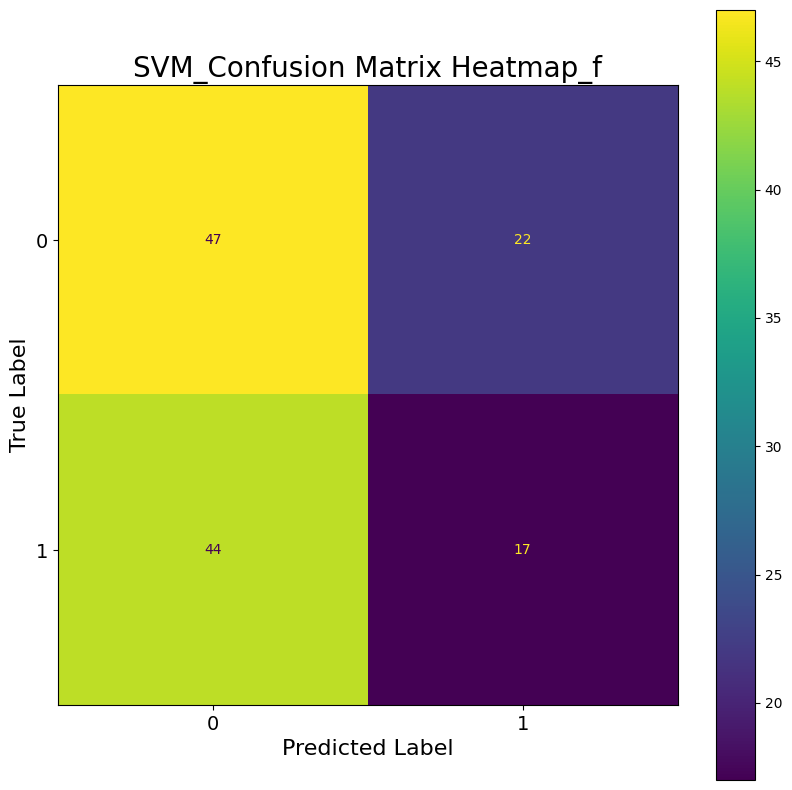

In [33]:
# Calculate the classification report
report_svm = classification_report(y_test_classes_svm, y_pred_classes_svm, output_dict=True)
print("Classification Report:")
print(report_svm)
report_df_svm = pd.DataFrame(report_svm).transpose()

report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

# Predict on the untouched data
y_untouch_classes_svm = np.argmax(y_untouch_svm, axis=-1)
y_pred_untouch_svm = svm_model.predict(X_untouch_svm)
# Calculate accuracy
accuracy_svm = accuracy_score(y_untouch_classes_svm, y_pred_untouch_svm)
print('Accuracy:', accuracy_svm)
report_svm = classification_report(y_untouch_classes_svm, y_pred_untouch_svm)
print("Classification Report:")
print(report_svm)
report_df_svm.to_excel(f"svm_validation_{folder_name}.xlsx", index=True)

# Compute the confusion matrix
cm_svm= confusion_matrix(y_test_classes_svm, y_pred_classes_svm)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm_svm).plot(ax=ax, cmap='viridis')
plt.title(f'SVM_Confusion Matrix Heatmap_{folder_name}', fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'SVM_confusion_matrix_heatmap_{folder_name}.png', dpi=300)
plt.show()